In [80]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import arviz as az
import pandas as pd
from datetime import datetime
import json
import argparse

import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

import scipy.io
from scipy.stats import zscore
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [81]:
 # Load .mat file
SalinasA= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_gt.mat')['salinasA_gt'])
#Salinas_gt_mod = np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_mod.nc')['salinasA_gt'])

In [82]:
import netCDF4 as nc
SalinasA_gt_mod = nc.Dataset('./HSI_Salinas/SalinasA_mod.nc',mode='r')
SalinasA_gt_mod.variables['data']

<class 'netCDF4._netCDF4.Variable'>
float64 data(x, y, z)
unlimited dimensions: 
current shape = (83, 86, 204)
filling on, default _FillValue of 9.969209968386869e+36 used

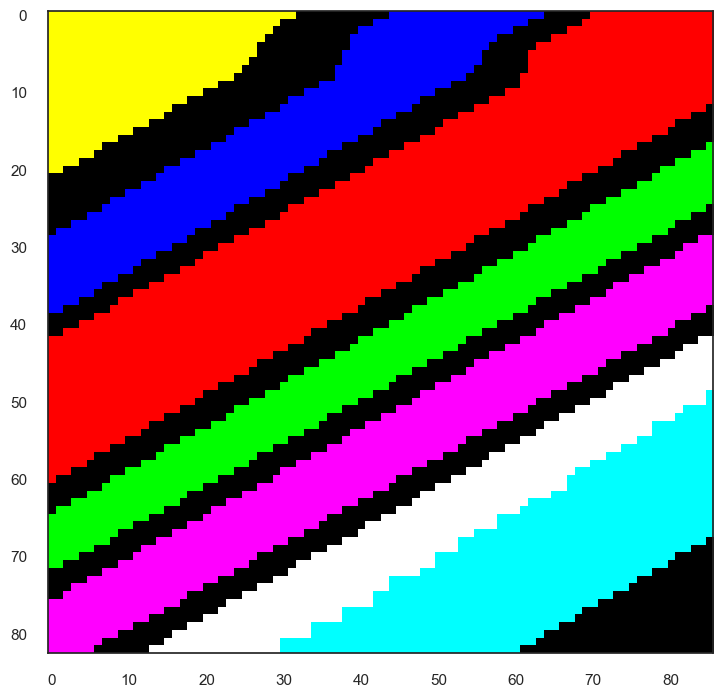

In [83]:
from skimage import io
# Load the image
image = io.imread('./HSI_Salinas/SalinasA_mod_gt.png')

# Show the image
io.imshow(image)
io.show()

# Access image data as a numpy array
#print(image)

In [84]:
from PIL import Image
# Define the RGB to label mapping for 8 labels
rgb_to_label = {
    (255, 0, 0): 1,       # Red to label 1
    (0, 255, 0): 2,       # Green to label 2
    (0, 0, 255): 3,       # Blue to label 3
    (255, 255, 0): 4,     # Yellow to label 4
    (255, 0, 255): 5,     # Magenta to label 5
    (0, 255, 255): 6,     # Cyan to label 6
    (255, 255, 255): 7,   # White to label 7
    (0, 0, 0): 8          # Black to label 8
}

# Load the image
image = Image.open('./HSI_Salinas/SalinasA_mod_gt.png')
image = image.convert('RGB')  # Ensure the image is in RGB mode

# Convert the image to a numpy array
image_array = np.array(image)

# Prepare an empty label array with the same dimensions as the image
label_array = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.int32)

# Iterate over the RGB-to-label mappings and apply them to the label array
for rgb, label in rgb_to_label.items():
    # Create a mask where all pixels match the current RGB value
    mask = np.all(image_array == rgb, axis=-1)
    # Assign the corresponding label to the label array
    label_array[mask] = label

# Now `label_array` contains the labels corresponding to the RGB image

# Optional: Convert the label array to an image (for visualization)
label_image = Image.fromarray(label_array.astype(np.uint8))
label_image.show()

In [85]:
label_array

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [5, 5, 5, ..., 8, 8, 8],
       [5, 5, 5, ..., 8, 8, 8],
       [5, 5, 5, ..., 8, 8, 8]], dtype=int32)

In [86]:
# Arrange the label in groundtruth
i=0
label_data = [0,6,1,5,4,3,2]

for ele in np.unique(SalinasA_gt):
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    i=i+1
    
np.unique(SalinasA_gt)


array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [97]:
SalinasA_gt+1

array([[7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5],
       ...,
       [3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1]], dtype=uint8)

In [89]:
(SalinasA_gt +1)[:,0]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1,
       1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3], dtype=uint8)

In [90]:
label_array[:,0]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8,
       8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 2,
       2, 2, 2, 2, 2, 2, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

In [91]:
SalinasA_gt_mod_ = np.zeros_like(label_array)
SalinasA_gt_mod_[label_array==8] =1
SalinasA_gt_mod_[label_array==7] =3
SalinasA_gt_mod_[label_array==6] =2
SalinasA_gt_mod_[label_array==5] =4
SalinasA_gt_mod_[label_array==4] =8
SalinasA_gt_mod_[label_array==3] =7
SalinasA_gt_mod_[label_array==2] =5
SalinasA_gt_mod_[label_array==1] =6



In [103]:
(SalinasA_gt_mod_ - (SalinasA_gt+1))[:,0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

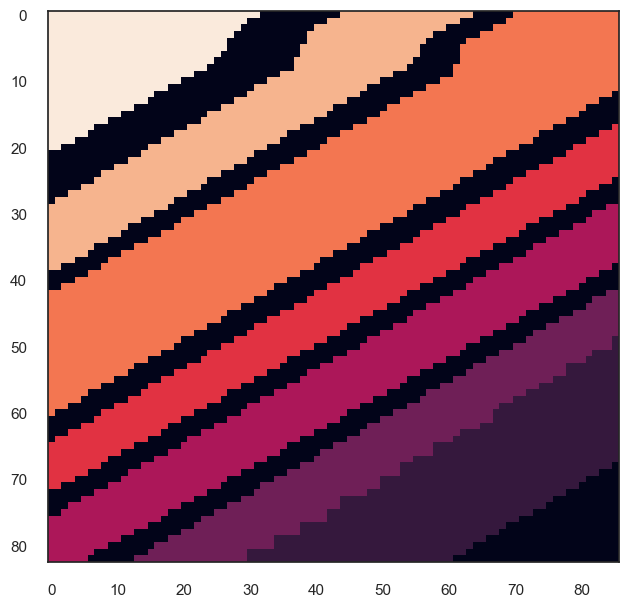

In [93]:
plt.imshow(SalinasA_gt_mod_)

In [114]:
SalinasA_gt_mod_[:,40]

array([1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2], dtype=int32)

In [111]:
SalinasA_gt_mod_.shape

(83, 86)

In [115]:
-83+6

-77

In [94]:
np.unique(SalinasA_gt_mod_)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [95]:
data_dict = {"salinasA_gt_mod": SalinasA_gt_mod_}
scipy.io.savemat('./HSI_Salinas/SalinasA_gt_mod.mat', data_dict)

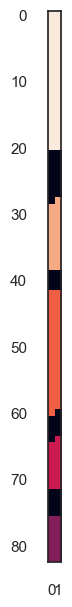

In [64]:
plt.imshow(SalinasA_gt[:,0:2])